# Monte Carlo Simulation of Scintillator and PMT for AESOP-Lite

### By Liam Branch and Robert Johnson

In [52]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import math
import random

### Links
- [Simple ray tracing](https://medium.com/swlh/ray-tracing-from-scratch-in-python-41670e6a96f9)
-[2D intersection circle](https://www.geometrictools.com/Documentation/IntersectionLine2Circle2.pdf)
- [3D intersection sphere](https://math.stackexchange.com/questions/2247498/intersection-of-ray-with-circle-in-3d-subject-to-endpoint-and-orientation-constr)
- [3D ray sphere v2](https://math.stackexchange.com/questions/70196/whats-the-distance-between-a-ray-and-a-sphere)
- [Chords on a circle](https://en.wikipedia.org/wiki/Chord_(geometry))
- [Fresnel equations](https://en.wikipedia.org/wiki/Fresnel_equations)

PDF Datasheets
- [Hamamatasu](hamamatsu.com/content/dam/hamamatsu-photonics/sites/documents/99_SALES_LIBRARY/etd/R2083_R3377_TPMH1227E.pdf)

In [4]:
# Constants
c = 0.0299792 # Speed of Light in cm / ps
# Measurements made on a Zoom call with James on March 6th,2022
# xPMT1=8.*cos(-45)*2.54
# yPMT1=8.*sin(-45)*2.54
#
# x2PMT1=8.*cos(-53.72)*2.54 # For test
# y2PMT1=8.*sin(-53.72)*2.54 # For test
#
# xPMT4=9.5*cos(110)*2.54
# yPMT4=9.5*sin(110)*2.54
# Estimated by Pierre-Simon on March 7th, 2002
# xPMT3=7.*cos(8))*2.54
# yPMT3=7.*sin(80)*2.54
# xPMTG=7.*cos(100)*2.54
# yPMTG=7.*sin(100)*2.54

# The radii of the scintillators are, in cm:
# Rad1=13
# Rad3=3.5
# RadGi=3.5
# RadGo=13.5
# Rad4=18

In [5]:
scint_radius = 13. # cm
scint_width = 0.5 #
width_pmt_window = 4 # cm
length_pmt_window = 1 #cm
width = width_pmt_window/2
length = length_pmt_window
theta_lim = np.arcsin(width/scint_radius)
# Position of PMT
x = width/np.tan(theta_lim) # thetax_0
y = -width
# Main Scintillator angles
theta_scint = np.linspace(theta_lim,2*np.pi-theta_lim, 100)

In [6]:
# def distance_solver(u, o, center, radius):
#     print("v",u,"CP",o,"radius",radius)
#     CP = center-o
#     OC = center # - (0,0)
#     u = u*-1 if np.dot(u,CP) < 0 else u # make sure vectors v and OP are in same half space\
#     n = np.cross(u, CP) #axisc=2)                 # orthogonal with plane of intersection points and line passing through center
#     print(CP,u, "n",n)
#     perp = normalize(np.cross(u, n)) if np.array(n).ndim > 2 else normalize(u*n)    # perp is parallel to line of intersection and orthogonal to v and n
#     Q2P = OC-radius*perp
#     cosalpha = np.dot(perp, normalize(Q2P))
#     rootA = -np.sqrt(np.sum((radius*perp + (radius/cosalpha)*normalize(Q2P))**2))
#     rootB = np.sqrt(np.sum((radius*perp + (radius/cosalpha)*normalize(Q2P))**2))
#     return -rootA if (rootA < 0) & (np.dot(u,CP) < 0) else (-rootB if np.dot(u,CP) < 0 else rootB)

### Particle path creator
I chose for the particle to appear first 2cm above the scintillator and then max angle of 40 degrees

In [69]:
def particle_path(t, T1_z, T1_width, T4_z, T4_width, mean_free_path, photons_per_energy):
    r = random.uniform(0,2*np.pi)
    theta = random.uniform(-20*np.pi/180,20*np.pi/180) # 40 degree range
    maxdist = np.random.random()*scint_radius/2
    o = (maxdist*np.cos(r), maxdist*np.sin(r), T1_z+T1_width+2) # x, y, z
    u = np.array((0,0,-1)) # just start with downwards paths
    # dist = (T1_top - o) / u
    # dist/c = time
    T1photons = 0
    T4photons = 0
    distances = np.zeros(4)
    points = [o]
    times = [t]
    for i,scint_pos in enumerate([T1_z+T1_width,T1_z,T4_z+T4_width,T4_z]):
        distances[i] = np.abs((scint_pos - o[2])/u[2]) # check if z is on boundary of scintillator
        if i==1: # if travelled distance from top to bottom of T1
            print(distances[i],mean_free_path,(distances[i]/mean_free_path))
            T1collisions = int(np.floor((distances[i]/mean_free_path))) # floor to number of collisions
            for _ in range(T1collisions):                               # from current time to time at other edge of scintillator
                t += mean_free_path/c
                times.append(t)                                         # save times of each collision
                points.append(points[-1] + mean_free_path*u)            # save point of each collision
            T1photons = T1collisions*np.random.poisson(photons_per_energy) # calculate number of photons per collision
        elif i==3: # if travelled distance from top to bottom of T4 
            T4collisions = int(np.floor((distances[i]/mean_free_path))) # floor to number of collisions
            for t_i in range(T4collisions):                             # from current time to time at other edge of scintillator
                t += mean_free_path/c
                times.append(t)                                         # save times of each collision 
                points.append(points[-1] + mean_free_path*u)            # save point of each collision
            T4photons = T4collisions*np.random.poisson(photons_per_energy) # calculate number of photons per collision
        else:
            t += distances[i]/c # calculate time in ps passed
            times.append(t)
    return np.array(times), np.array(points)

3.0 0.2 15.0


<IPython.core.display.Javascript object>


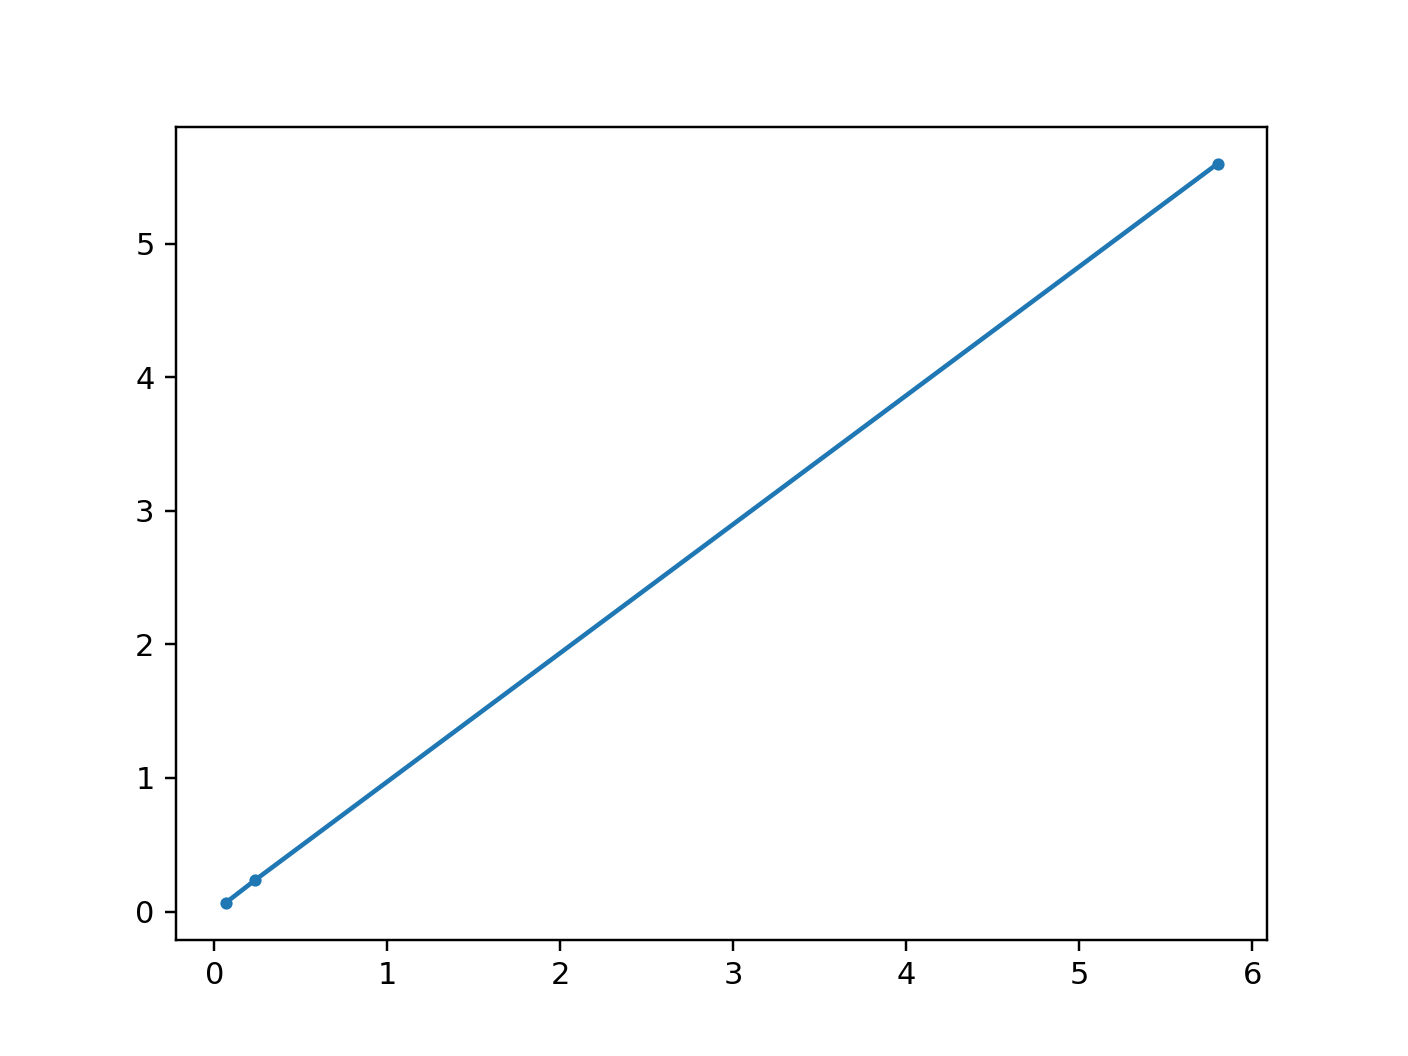

[]

In [73]:
times, points = particle_path(t=0, T1_z=3, T1_width=1, T4_z=0, T4_width=1, mean_free_path=0.2, photons_per_energy=10)
# print(times)
# print(points)
plt.plot(points[1],points[0,0,:],marker='.')
plt.plot()

### Photon path tracker

In [7]:
def normalize(x):
    x /= np.linalg.norm(x)
    return x
def mag(x):
    return np.linalg.norm(x)

In [8]:
def distance_solver(u, o, center, radius, plane):
    dcircle = distance_circle(u,o,center,radius)
    dplane = distance_plane(u,o,plane)
    return dplane if dcircle > dplane else dcircle
def distance_circle(u, o, center, radius): #3d directional vector, 3d point, center of scintillator, radius of scintillator
    P = o
    D = u*-1 if np.dot(u,P) < 0 else u
    C = center
    R = radius
    bigDelta = P-C
    # t = -D . ∆ ± √(D . ∆)^2 - |D|^2(|∆|^2 - R^2)
    #     over |D|^2
    magDsq = mag(D)**2
    magDeltasq = mag(bigDelta)**2
    DdotDelta = np.dot(D,bigDelta)
    sqrt_term = np.sqrt(DdotDelta**2 - magDsq * (magDeltasq - R**2))/magDsq
    b_term = -DdotDelta/magDsq
    rootA = b_term - sqrt_term
    rootB = b_term + sqrt_term
    return np.abs(rootA) if (rootA < 0) & (np.dot(u,P) < 0) else np.abs(rootB)
#     return -rootA if (rootA < 0) & (np.dot(u,P) < 0) else (-rootB if np.dot(u,P) < 0 else rootB)
def distance_plane(u, o, plane): #3d directional vector, 3d point, z positions of planes bottom and top
    P = o
    z_plane = plane[0] if u[2] < 0 else plane[1] # make sure direction matches location of plane 
    return np.abs((z_plane - P[2])/u[2])

**Geometries**

In [9]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 20)
    theta = np.linspace(0, 2*np.pi, 20)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

$$ R_s = \Bigg\vert\frac{n_1\cos\theta_i - n_2\cos\theta_t}{n_1\cos\theta_i+n_2\cos\theta_t}\Bigg\vert^2 = 
\Bigg\vert \frac{n_1\cos\theta_i - n_2\sqrt{1-\Big(\frac{n_1}{n_2}\sin\theta_i\Big)^2}}{n_1\cos\theta_i + n_2\sqrt{1-\Big(\frac{n_1}{n_2}\sin\theta_i\Big)^2}}\Bigg\vert^2
$$
$$ R_p = \Bigg\vert\frac{n_1\cos\theta_t - n_2\cos\theta_i}{n_1\cos\theta_t+n_2\cos\theta_i}\Bigg\vert^2 = 
\Bigg\vert \frac{n_1\sqrt{1-\Big(\frac{n_1}{n_2}\sin\theta_i\Big)^2} - n_2\cos\theta_i}{n_1\sqrt{1-\Big(\frac{n_1}{n_2}\sin\theta_i\Big)^2} + n_2\cos\theta_i}\Bigg\vert^2
$$

$$ \sin\theta = \frac{\lVert \vec u \times \vec n \lVert}{\lVert \vec u \lVert \lVert \vec n \lVert}$$

In [10]:
def photon_interaction(u, n, E):
    u_i = u
    u_r = u - 2*np.dot(u, n)*n # u_new = u - 2 (u . n)*n
    # CONDITION n_1 <= n_2
    n_1 = 1.000293 # 1.85 for NaI
    n_2 = 1.5 # Sample index of refraction of air
    v = u*-1 if np.dot(u,n) < 0 else u
    theta = np.arcsin(mag(np.cross(v,n))/(mag(u)*mag(n)))
#     theta = np.arccos(mag(np.dot(v,n))/(mag(u)*mag(n)))
    inside_sqrt = ((n_1/n_2)*np.sin(theta))**2
    sqrt_term = np.sqrt(1 - inside_sqrt)
    Rs = np.abs((n_1*np.cos(theta) - n_2*sqrt_term)/(n_1*np.cos(theta) + n_2*sqrt_term))**2
    Rp = np.abs((n_1*sqrt_term - n_2*np.cos(theta))/(n_1*sqrt_term + n_2*np.cos(theta)))**2
    E *= (Rs+Rp)/2 # energy loss n of photon using Reflectance
    return u_r, E

def scintillator_monte_carlo(o, x_pmt, E, scint_radius, scint_plane, N_max, dt):
    print(f"Starting position (x_0,y_0,z_0) = ({o[0]:.2f},{o[1]:.2f},{o[2]:.2f})")
    track_history = np.zeros((N_max+1,7))         # x, y history of Photon
    theta = random.uniform(0,2*np.pi)           # first theta direction of photon
    phi = random.uniform(0,np.pi)               # first phi   direction of photon
    u = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]) # first direction unit vector
    track_history[0,:] = [o[0],o[1],o[2],u[0],u[1],u[2],E]
    i = 1
    while (i < N_max+1) & (o[0] < x_pmt) & (E > 0.1):
        ds = distance_solver(u, o, np.zeros(3),scint_radius, scint_plane)
        x, y, z = o+ds*u
        dt = np.abs(ds)/c if np.abs(ds)>1e-9 else float('inf')  # time taken in ps traveling in direction theta
        print(f"step {i}: ds={ds:.2f}cm dt={dt:.2f}ps E={E:.2f} xyz =({x:.2f},{y:.2f},{z:.2f}) u=({u[0]:.2f},{u[1]:.2f},{u[2]:.2f})")
        o = np.array([x, y, np.abs(z) if np.abs(z-scint_plane).any() < 1e-5 else z])
        if z == scint_plane[0]:
            n = np.array([0,0,+1])
        elif z == scint_plane[1]:
            n = np.array([0,0,-1])
        else:
            n = normalize(o-np.zeros(3))
        u, E = photon_interaction(u, n, E)
        track_history[i] = [x,y,z,u[0],u[1],u[2],E]
        i+=1
    if i < N_max+1:
        track_history = track_history[:i,:]
        
    print(f"DONE E left={E}")
    return track_history

<IPython.core.display.Javascript object>


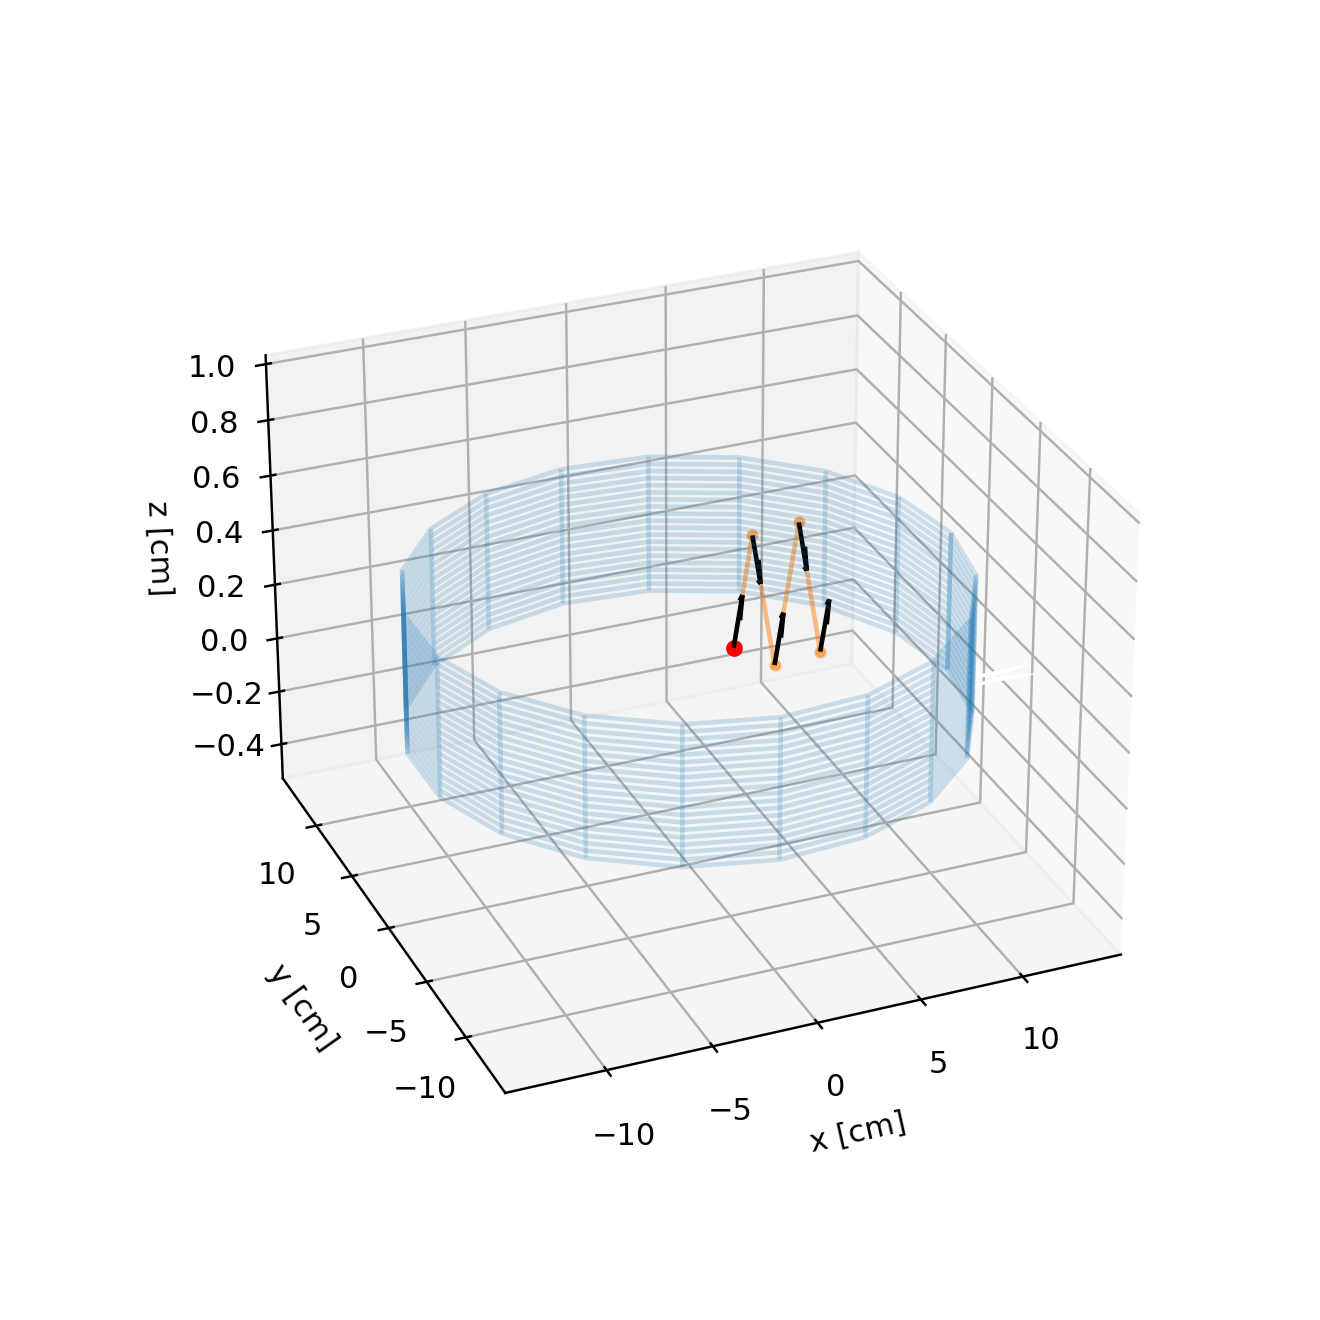

Starting position (x_0,y_0,z_0) = (3.55,3.12,0.11)
step 1: ds=1.06cm dt=35.35ps E=100.00 xyz =(4.52,3.27,0.50) u=(0.92,0.14,0.37)
step 2: ds=1.35cm dt=45.14ps E=15.12 xyz =(5.76,3.46,0.00) u=(0.92,0.14,-0.37)
step 3: ds=1.35cm dt=45.14ps E=2.29 xyz =(7.00,3.65,0.50) u=(0.92,0.14,0.37)
step 4: ds=1.35cm dt=45.14ps E=0.35 xyz =(8.25,3.85,0.00) u=(0.92,0.14,-0.37)
DONE E left=0.052240854670186944


In [31]:
# Plot
fig0 = plt.figure(figsize=(6,6))
ax0 = fig0.add_subplot(111, projection='3d')
# ax0.plot(scint_radius*np.cos(theta_scint), scint_radius*np.sin(theta_scint), 0)
X, Y, Z = data_for_cylinder_along_z(0,0,scint_radius,0.5)
ax0.plot_wireframe(X, Y, Z, alpha=0.2)
r = random.uniform(0,2*np.pi)
maxdist = np.random.random()*scint_radius
random_track = (maxdist*np.cos(r), maxdist*np.sin(r), np.random.random()*scint_width) # x, y
ax0.scatter(random_track[0],random_track[1],random_track[2], color='red', marker='o')
# pmt_window = plt.Rectangle((x,y), length_pmt_window, width_pmt_window, fc='blue', alpha=0.5)
y_plus_l = y+length_pmt_window
x_plus_w = x+width_pmt_window
x_pmt = [x,x_plus_w,x,x_plus_w]
y_pmt = [y,y,y_plus_l,y_plus_l]
z_pmt = [0,0,0,0]
verts = [list(zip(x_pmt,y_pmt,z_pmt))]

ax0.add_collection3d(Poly3DCollection(verts, facecolors='w'))
# plt.show()
# ax0.add_patch(pmt_window)
tracks = scintillator_monte_carlo(random_track, x_pmt=scint_radius, E=100, scint_radius=scint_radius, scint_plane=np.array([0.0,0.5]), N_max=8, dt=0.2)
# for i in range(len(tracks[:,0])):
#     x,y,z,u0,u1,u2 = tracks[i,0],tracks[i,1],tracks[i,2], tracks[i,3], tracks[i,4],tracks[i,5]
#     print(f"xyz=({x:.2f},{y:.2f},{z:.2f}) u=({u0:.2f},{u1:.2f},{u2:.2f})")
ax0.quiver(tracks[:,0],tracks[:,1],tracks[:,2], tracks[:,3], tracks[:,4],tracks[:,5], length=np.array([0,0.5]).max(), edgecolor='k', facecolor='black', linewidth=1.5)#, pivot='tail')#, normalize=True)
\
# ax0.quiver(tracks[:,0],tracks[:,1],tracks[:,2], tracks[:,3], tracks[:,4],tracks[:,5], scale=10)
line = ax0.plot(tracks[:,0],tracks[:,1],tracks[:,2], alpha=0.5, color='C1', marker='.')
ax0.grid(True)
ax0.set_xlabel('x [cm]')
ax0.set_ylabel('y [cm]')
ax0.set_zlabel('z [cm]')
ax0.set_zlim([-0.5,1])
plt.show()

### Light Guide Building

How about if we build the tube as a square with a condition past a plane to continute to reflect to the PMT

In [291]:
def waveguide_plane(scint_radius):
    x = np.linspace(-2,2,20)
    z = np.linspace(-2,2,20)
    X,Z = np.meshgrid(x,z)
    # r*X + r*Y = r^2
    Y = scint_radius - scint_radius*X
    return X, Y, Z

<IPython.core.display.Javascript object>


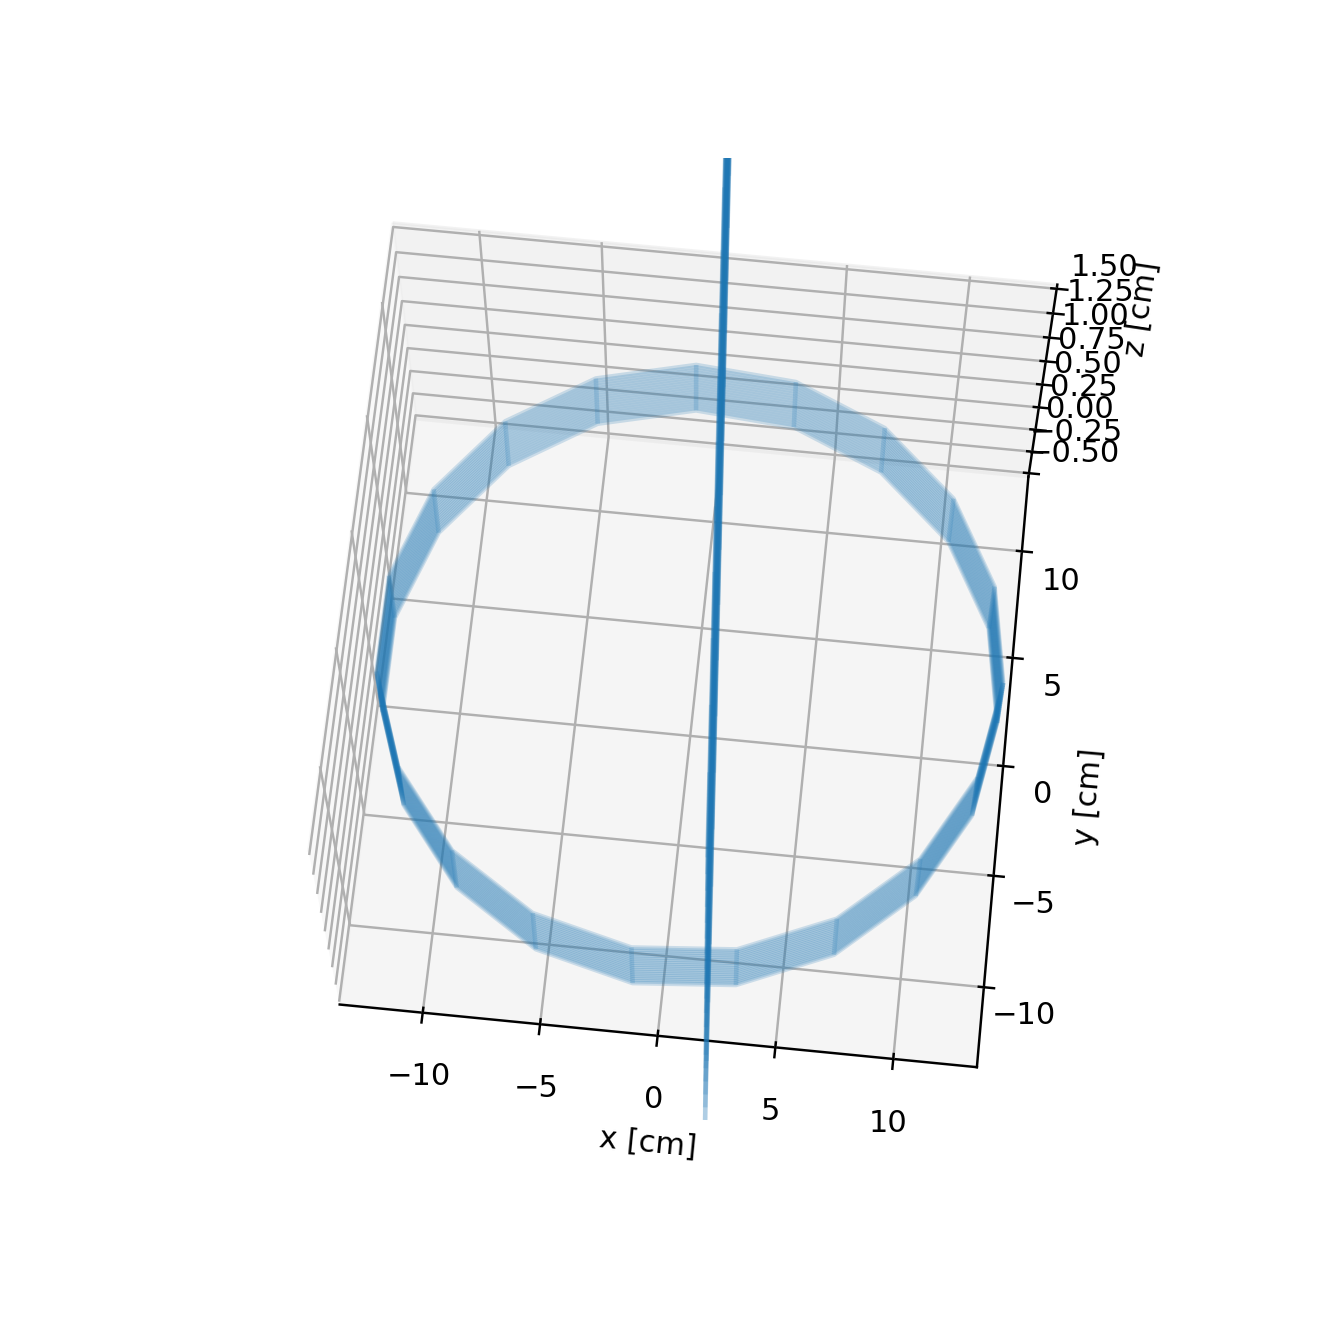

In [293]:
# Light tube building
fig1 = plt.figure(figsize=(6,6))
ax1 = fig1.add_subplot(111, projection='3d')
X, Y, Z = data_for_cylinder_along_z(0,0,scint_radius,0.5)
ax1.plot_wireframe(X, Y, Z, alpha=0.2)
X1, Y1, Z1 = waveguide_plane(scint_radius)
ax1.plot_wireframe(X1, Y1, Z1, alpha=0.2)
ax1.set_xlabel('x [cm]')
ax1.set_ylabel('y [cm]')
ax1.set_zlabel('z [cm]')
ax1.set_xlim([-13,13])
ax1.set_ylim([-13,13])
ax1.set_zlim([-0.5,1.5])
plt.show()

- Light tube add is very important for shape of scintilator
- T1: 0.5cm, T4:1cm
- find a mean free path and then at each mean calculate the random.poisson(mean) which is the time to the next scintillation
- at the reflection there is a high chance of absorption -> figure out this probability based off of the properties of the scintillator --> fresnel's equation and white paint layer?
- 

### PMT signal making

In [246]:
# Taken from c code resource
def photoElectrons(photons, QE):
    n = 0.
    for i in range(photons):
        if np.random.random()<QE:
            n+=1
    return n

def meanDynodeElectrons(E):
    E_per_Electron = 20
    return E/E_per_Electron if E >= 0 else 0

def genDynodeElectrons(E_incoming, E):
    mean = E_incoming*meanDynodeElectrons(E)
    return np.random.poisson(mean)

def photontoElectrons(photons, voltages, QE, N):
    e = photoElectrons(photons, QE)
    prevV = 0.
    for dynode in range(N):
        delta_voltage = V[dynode] - prevV
        e += genDynodeElectrons(e, delta_voltage)
        prevV = V[dynode]
    return e

In [247]:
n_dynodes = 8
V = np.linspace(150,850,n_dynodes)
# V = [150,300,350,600,750,850]
n_incident_photons = 10000
QE = 0.23
pmtSignal = []
for photon in range(n_incident_photons):
    e = photontoElectrons(1, V, QE, n_dynodes)
    if e>1:
        pmtSignal.append(e)

Dynode Voltages = [150. 250. 350. 450. 550. 650. 750. 850.]


<IPython.core.display.Javascript object>


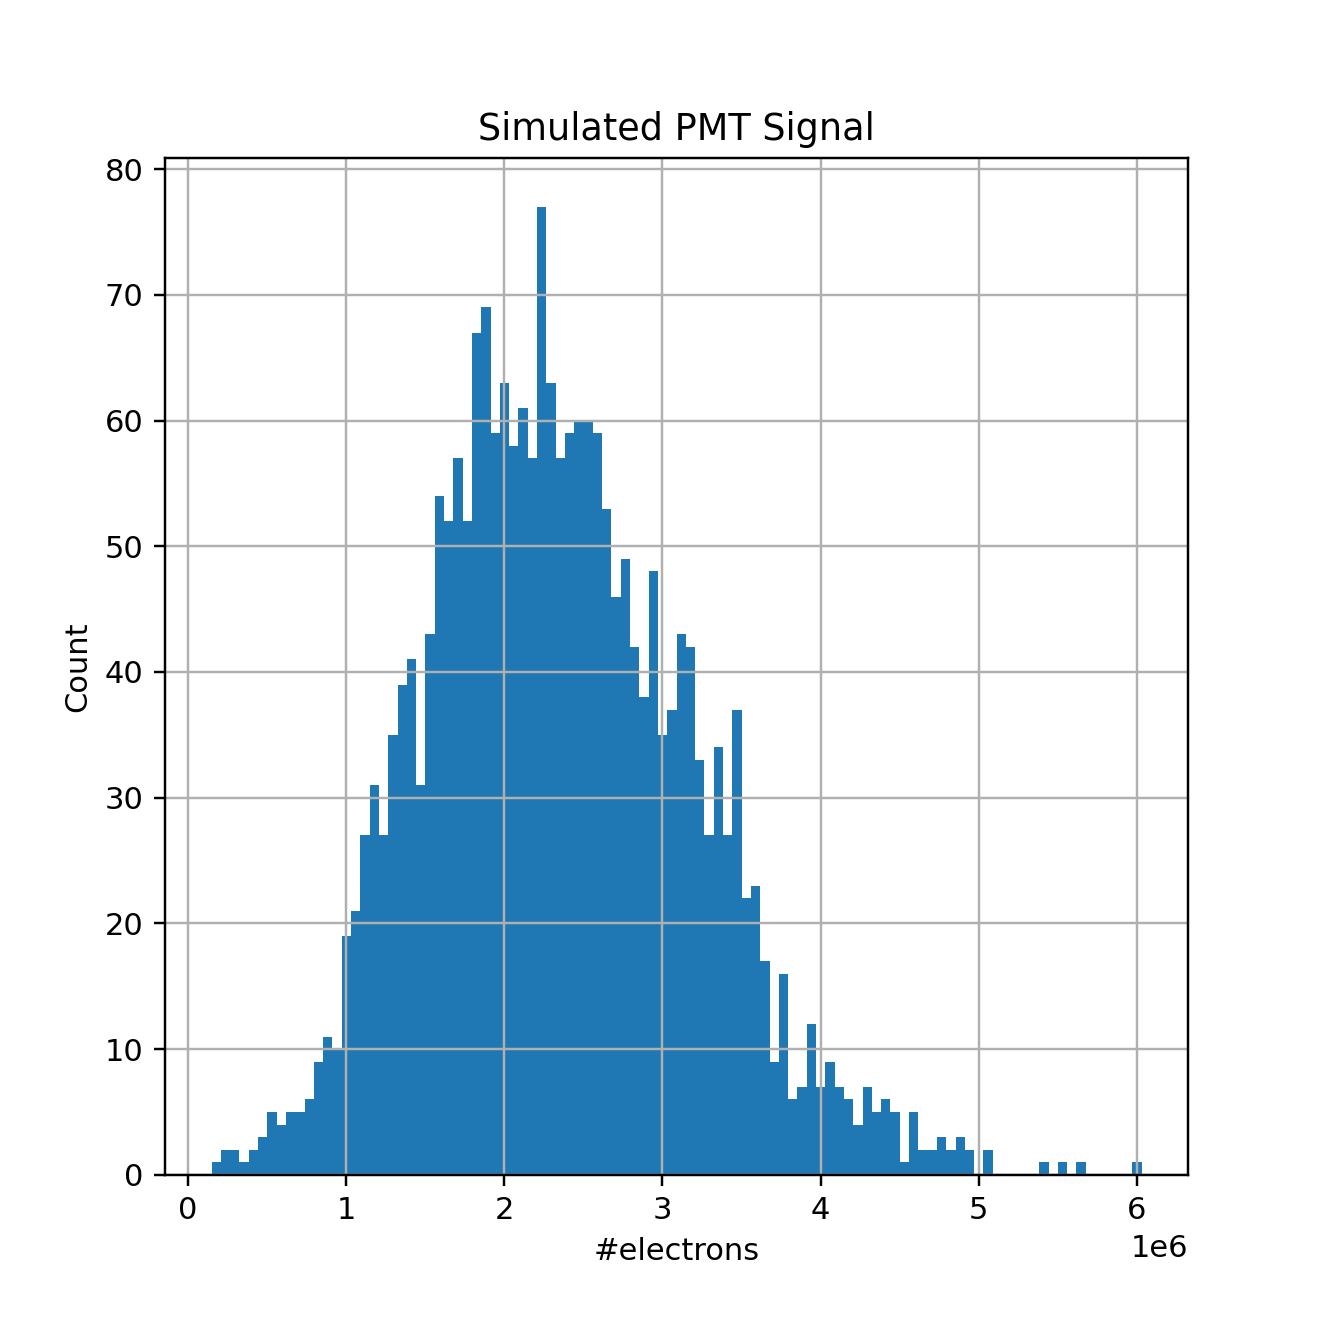

In [248]:
print("Dynode Voltages =", V)
fig1, ax1 = plt.subplots(figsize=(6,6))
counts1, bins1 = np.histogram(pmtSignal, bins=40)
logbins1 = np.logspace(np.log10(bins1[0]),np.log10(bins1[-1]),len(bins1))
ax1.hist(pmtSignal, bins=100)
ax1.set_title('Simulated PMT Signal')
ax1.set_ylabel('Count')
ax1.set_xlabel('#electrons')
# ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.grid(True)
plt.show()